# Prueba ML: analisis de concentracion de silice

Nota: acentos y tildes propias del espanol han sido omitidas

## Predecir el % de concentrado de silice

### Librerias

In [238]:
# librerias que se usaran
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

### Algunas funciones 

In [288]:
def model_summaries(model, X, y):
    # para ver efecto de las variables en el modelo
    scaler = scale.fit(X)
    Z = scaler.transform(X)
    model.fit(Z, y)
    coef_Z = model.coef_.round(4)
    
    # modelo
    model.fit(X, y)
    print("R2 is", round(model.score(X, y), 4))
    print("Intercept is ", round(model.intercept_, 4))
    
    coeficientes = pd.DataFrame([X.columns, model.coef_.round(4), coef_Z]).T
    coeficientes.columns = ['variable', 'beta', 'beta_var_Z']
    print(coeficientes)
    

def metrics_on_test(pred, y):
    
    print("R2 is  ", round(r2_score(y, pred), 4))
    print("MSE is ", round(mean_squared_error(y, pred), 4))
    print("MAE is ", round(mean_absolute_error(y, pred), 4))

## Estrategia

Primero voy a cargar los datos y hacer un analisis descriptivo numerico y grafico. 
Segundo, voy a agregar la informacion a nivel de dia - hora.
Tercero, mirare la evolucion temporal de los datos y discutire metodolosgias de modelamiento.
Cuarto, llevare a cabo el analisis estadistico.
Quinto, analizare el modelo seleccionado y mostrare una grafica sobre evolucion de % de concentracion de silice.

## 1. Cargar datos

In [2]:
# cargar datos
data = pd.read_csv("./Data/MiningProcess_Flotation_Plant_Database.csv", 
                     sep = ',', decimal = ',')

### Informacion basica sobre los datos:

In [3]:
# primeras filas
data.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [4]:
# numero de registros y numero de columnas
data.shape

(737453, 24)

### Creacion de nuevas variables temporales 

In [5]:
# columna date a to_datetime  agregamos algunas columnas relacionadas con la fecha
data['date'] = pd.to_datetime(data['date'], yearfirst = True)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['time'] = data['date'].dt.time
data['hour'] = data['date'].dt.hour
data['fecha'] = data['date'].dt.date
# transformacion de mes - dia a numero
data['month_day_aux'] = data['date'].dt.month * 100 + data['date'].dt.day

In [42]:
# informacion general
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

### Algunas medidas descriptivas

In [7]:
data.iloc[:, :8].describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250


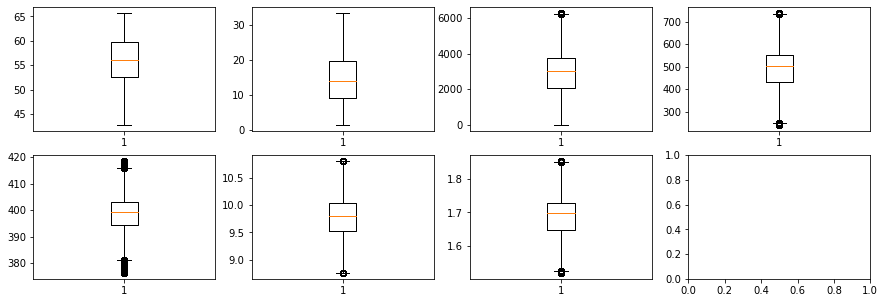

In [8]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(data['% Iron Feed']);
axs[0,1].boxplot(data['% Silica Feed']);
axs[0,2].boxplot(data['Starch Flow']);
axs[0,3].boxplot(data['Amina Flow']);

axs[1,0].boxplot(data['Ore Pulp Flow']);
axs[1,1].boxplot(data['Ore Pulp pH']);
axs[1,2].boxplot(data['Ore Pulp Density']);

In [9]:
data.iloc[:, 8:15].describe()

,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,280.151856,277.159965,281.082397,299.447794,299.917814,292.071485,290.754856
std,29.621288,30.149357,28.558268,2.572538,3.636579,30.217804,28.670105
min,175.510000,175.156000,176.469000,292.195000,286.295000,189.928000,185.962000
25%,250.281000,250.457000,250.855000,298.262566,298.068000,262.541000,256.302000
50%,299.344000,296.223000,298.696000,299.805000,299.887120,299.477000,299.011000
75%,300.149000,300.690000,300.382000,300.638000,301.791137,303.061000,301.904000
max,373.871000,375.992000,364.346000,305.871000,310.270000,370.910000,371.593000


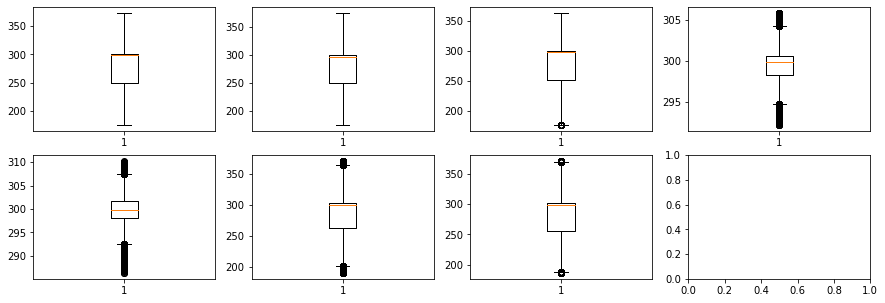

In [10]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(data['Flotation Column 01 Air Flow']);
axs[0,1].boxplot(data['Flotation Column 02 Air Flow']);
axs[0,2].boxplot(data['Flotation Column 03 Air Flow']);
axs[0,3].boxplot(data['Flotation Column 04 Air Flow']);

axs[1,0].boxplot(data['Flotation Column 05 Air Flow']);
axs[1,1].boxplot(data['Flotation Column 06 Air Flow']);
axs[1,2].boxplot(data['Flotation Column 07 Air Flow']);

In [11]:
data.iloc[:, 15:22].describe()

,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231
std,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491
min,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000
25%,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000
50%,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000
75%,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000
max,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000


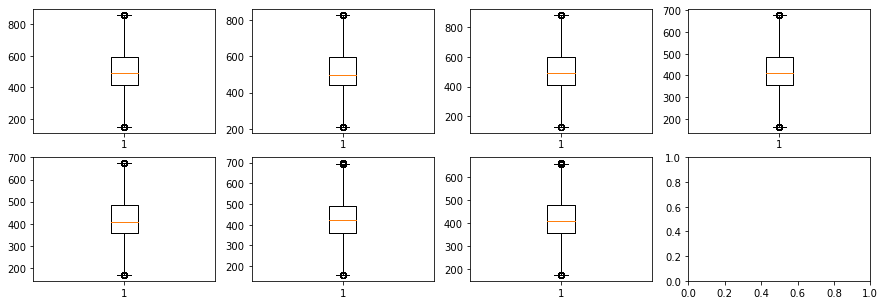

In [12]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(data['Flotation Column 01 Level']);
axs[0,1].boxplot(data['Flotation Column 02 Level']);
axs[0,2].boxplot(data['Flotation Column 03 Level']);
axs[0,3].boxplot(data['Flotation Column 04 Level']);

axs[1,0].boxplot(data['Flotation Column 05 Level']);
axs[1,1].boxplot(data['Flotation Column 06 Level']);
axs[1,2].boxplot(data['Flotation Column 07 Level']);

In [13]:
data.iloc[:, 22:24].describe()

,% Iron Concentrate,% Silica Concentrate
count,737453.000000,737453.000000
mean,65.050068,2.326763
std,1.118645,1.125554
min,62.050000,0.600000
25%,64.370000,1.440000
50%,65.210000,2.000000
75%,65.860000,3.010000
max,68.010000,5.530000


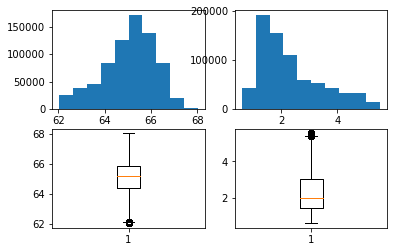

In [14]:
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(data['% Iron Concentrate']);
axs[0,1].hist(data['% Silica Concentrate']);
axs[1,0].boxplot(data['% Iron Concentrate']);
axs[1,1].boxplot(data['% Silica Concentrate']);

Algunos comentarios:\
    - Se observa presencia de outliers y asimetria para algunas variables explicactivas.\
	- La variable objectivo, % concentracion silica, luce levemente asimetrica con algunos outliers\

Como hay variables que se miden cada 20seg y otras cada 1 hora, voy a agregar la informacion en los datos.  Como hay algunas asimetrias en las variables explicativas, usare la media y mediana para hacer esta agregacion.

## 2. Agregamos % concentracion silica con distintas unidades temporales

In [282]:
# agregacion a nivel de fecha y hora
data_agg_fecha_hora = data.groupby(['date'])['% Silica Concentrate'].agg(['mean', 'median']).reset_index() 
# agregacion a nivel de hora 
data_agg_hora = data.groupby(['hour'])['% Silica Concentrate'].agg(['mean', 'median']).reset_index() 
# agregacion a nivel de fecha y hora (auxiliar)
data_agg_fecha_hora2 = data.groupby(['fecha', 'hour'])['% Silica Concentrate'].agg(['mean']).reset_index() 

## 3. Evoluacion Temporal de % de concentracion silice y discusion de metodologias

### Evolucion historica a nivel de dia y hora

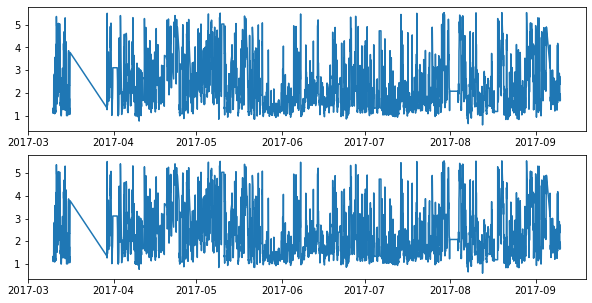

In [284]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 5))
ax1.plot(data_agg_fecha_hora.date, data_agg_fecha_hora.iloc[:, 1]); # media
ax2.plot(data_agg_fecha_hora.date, data_agg_fecha_hora.iloc[:, 2]); # mediana

Comentarios:\
    - no hay diferencias entre media y mediana a nivel dia-hora\
    - no se observan grandes tendencias o estacionalidades

###  Evolucion a nivel de hora

In [17]:
data_agg_hora = data.groupby(['hour'])['% Silica Concentrate'].agg(['mean', 'median']).reset_index() # name = ['silica_mean', 'silica_median']

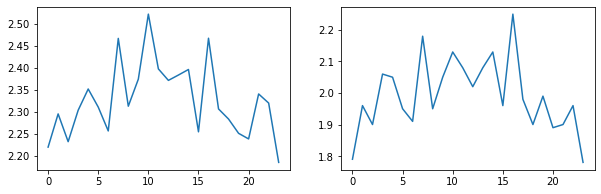

In [286]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3))
ax1.plot(data_agg_hora.hour, data_agg_hora.iloc[:, 1]);
ax2.plot(data_agg_hora.hour, data_agg_hora.iloc[:, 2]);

Comentario:

    - se ve patron de tendencia al alza y luego a la baja

Discusion de modelamiento:

Ya que es de interes analizar el % de concentracion silica a nivel de horas y también interesa saber como otras variables explican el % de concentracion silica voy a usar modelos de regresion. Modelo agregados como xgboost, lightGBM, entre otros, conocidos por su grande nivel de desempeño son los consideraré ya que la componente temporal (evolucion de % de concentracion silice durante el dia) se "pierde".

## 4. Analisis estadistico

Los datos los voy a agregar por dia y hora usando la media de cada variable ya que a nivel dia-hora la diferencia con la mediana es pequena.

### Preparamos la data a usar

In [21]:
variables = ['month_day_aux', 'hour',
             '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate']

In [49]:
df = data.groupby(['month_day_aux', 'hour'])[variables[2:(len(variables)+1)]].agg(['mean']).reset_index()
df.columns = variables

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   month_day_aux                 4097 non-null   int64  
 1   hour                          4097 non-null   int64  
 2   % Iron Feed                   4097 non-null   float64
 3   % Silica Feed                 4097 non-null   float64
 4   Starch Flow                   4097 non-null   float64
 5   Amina Flow                    4097 non-null   float64
 6   Ore Pulp Flow                 4097 non-null   float64
 7   Ore Pulp pH                   4097 non-null   float64
 8   Ore Pulp Density              4097 non-null   float64
 9   Flotation Column 01 Air Flow  4097 non-null   float64
 10  Flotation Column 02 Air Flow  4097 non-null   float64
 11  Flotation Column 03 Air Flow  4097 non-null   float64
 12  Flotation Column 04 Air Flow  4097 non-null   float64
 13  Flo

### Repetimos analisis descriptivo previo 

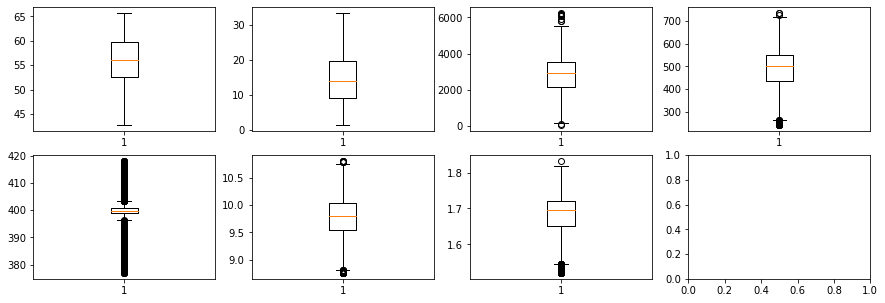

In [24]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(df['% Iron Feed']);
axs[0,1].boxplot(df['% Silica Feed']);
axs[0,2].boxplot(df['Starch Flow']);
axs[0,3].boxplot(df['Amina Flow']);

axs[1,0].boxplot(df['Ore Pulp Flow']);
axs[1,1].boxplot(df['Ore Pulp pH']);
axs[1,2].boxplot(df['Ore Pulp Density']);

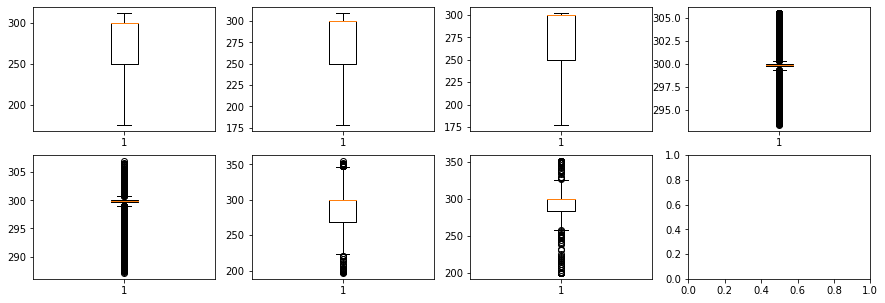

In [25]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(df['Flotation Column 01 Air Flow']);
axs[0,1].boxplot(df['Flotation Column 02 Air Flow']);
axs[0,2].boxplot(df['Flotation Column 03 Air Flow']);
axs[0,3].boxplot(df['Flotation Column 04 Air Flow']);

axs[1,0].boxplot(df['Flotation Column 05 Air Flow']);
axs[1,1].boxplot(df['Flotation Column 06 Air Flow']);
axs[1,2].boxplot(df['Flotation Column 07 Air Flow']);

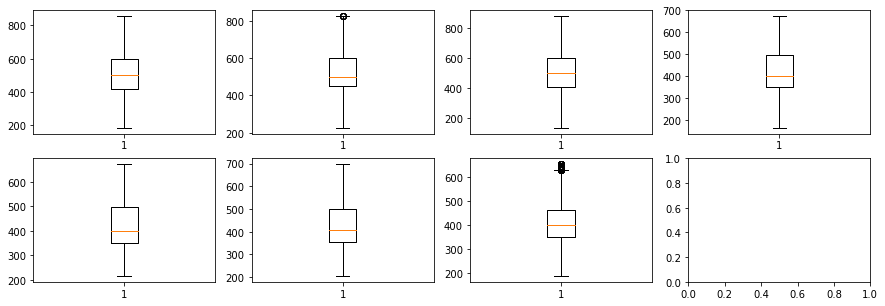

In [26]:
fig, axs = plt.subplots(2, 4, figsize = (15, 5))
axs[0,0].boxplot(df['Flotation Column 01 Level']);
axs[0,1].boxplot(df['Flotation Column 02 Level']);
axs[0,2].boxplot(df['Flotation Column 03 Level']);
axs[0,3].boxplot(df['Flotation Column 04 Level']);

axs[1,0].boxplot(df['Flotation Column 05 Level']);
axs[1,1].boxplot(df['Flotation Column 06 Level']);
axs[1,2].boxplot(df['Flotation Column 07 Level']);

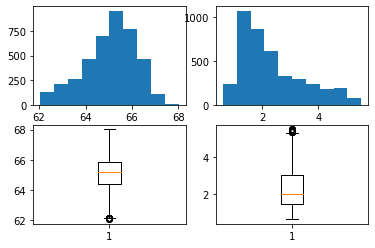

In [27]:
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(df['% Iron Concentrate']);
axs[0,1].hist(df['% Silica Concentrate']);
axs[1,0].boxplot(df['% Iron Concentrate']);
axs[1,1].boxplot(df['% Silica Concentrate']);

La data no presenta datos faltantes. Los boxplot de algunas variables como Flotation Column 05 Air Flow lucen con muchos outliers.

### Matriz de diseno

Incluyo la variable 'horas' como dummy, removiendo la hora 24 para evitar sobre parametrizacion. Asi, dado un set de varlores para las covariables, se podra caracterizar el % de concentracion silica para cada hora del dia. 

In [290]:
df_cat = df
dummies = pd.get_dummies(df_cat['hour'], prefix='hour', drop_first=True)
df_cat = df_cat.drop(['month_day_aux', 'hour'], axis=1)

In [291]:
df_categorical = pd.concat([df_cat, dummies], axis=1)

### Division entre training y testing data

Como la informacion historica disponible es medida en el tiempo, no voy a usar validacion cruzada para elegir el modelo. Voy a dividir la data en pasado (mediciones registradas antes de agosto) y futuro (mediciones despues de agosto) y comparare el desempeño de los modelos en la data del futuro. Que es lo que hace mas sentido en este contexto. 

In [135]:
train = df_categorical[df.month_day_aux < 800]
test = df_categorical[df.month_day_aux >= 800]

In [136]:
train.shape, test.shape

((3137, 46), (960, 46))

Asi uso ~25% de los datos en testing y 75% de los datos para training

In [ ]:
X = train.loc[:, train.columns != '% Silica Concentrate']
y = train['% Silica Concentrate']
X_test = test.loc[:, test.columns != '% Silica Concentrate']
y_test = test['% Silica Concentrate']

### Modelo de regresion lineal

In [293]:
reg = LinearRegression()
model_summaries(reg, X, y)

R2 is 0.6856
Intercept is  33.0305
                        variable    beta beta_var_Z
0                    % Iron Feed  0.0265     0.1361
1                  % Silica Feed  0.0317     0.2074
2                    Starch Flow    -0.0    -0.0385
3                     Amina Flow  0.0002     0.0189
4                  Ore Pulp Flow  0.0024     0.0088
5                    Ore Pulp pH  0.1627     0.0558
6               Ore Pulp Density  0.6718     0.0453
7   Flotation Column 01 Air Flow -0.0043    -0.1319
8   Flotation Column 02 Air Flow -0.0015    -0.0456
9   Flotation Column 03 Air Flow -0.0012    -0.0353
10  Flotation Column 04 Air Flow  0.0303     0.0627
11  Flotation Column 05 Air Flow  0.0286     0.0882
12  Flotation Column 06 Air Flow -0.0068     -0.162
13  Flotation Column 07 Air Flow  0.0049     0.1153
14     Flotation Column 01 Level -0.0003    -0.0362
15     Flotation Column 02 Level -0.0004    -0.0558
16     Flotation Column 03 Level -0.0002    -0.0344
17     Flotation Column 04 Le

In [294]:
metrics_on_test(reg.predict(X_test), y_test)

R2 is   0.6285
MSE is  0.4784
MAE is  0.5341


### Modelo de regression lineal con penalizacion lasso

In [295]:
lasso = linear_model.Lasso(alpha=0.1)
model_summaries(lasso, X, y)

R2 is 0.6686
Intercept is  47.822
                        variable    beta beta_var_Z
0                    % Iron Feed    -0.0       -0.0
1                  % Silica Feed  0.0091        0.0
2                    Starch Flow    -0.0       -0.0
3                     Amina Flow  0.0007        0.0
4                  Ore Pulp Flow     0.0        0.0
5                    Ore Pulp pH     0.0       -0.0
6               Ore Pulp Density     0.0        0.0
7   Flotation Column 01 Air Flow -0.0051    -0.0575
8   Flotation Column 02 Air Flow -0.0008       -0.0
9   Flotation Column 03 Air Flow -0.0009    -0.0054
10  Flotation Column 04 Air Flow     0.0       -0.0
11  Flotation Column 05 Air Flow   0.005        0.0
12  Flotation Column 06 Air Flow -0.0001       -0.0
13  Flotation Column 07 Air Flow     0.0       -0.0
14     Flotation Column 01 Level -0.0001       -0.0
15     Flotation Column 02 Level -0.0004       -0.0
16     Flotation Column 03 Level -0.0002       -0.0
17     Flotation Column 04 Lev

In [255]:
metrics_on_test(lasso.predict(X_test), y_test)

R2 is   0.6741
MSE is  0.4197
MAE is  0.5086


## Modelo de regresion elastic net

In [256]:
elastic = ElasticNet(random_state=0)
model_summaries(elastic, X, y)

R2 is 0.4053
Intercept is  20.3243
                        variable    beta beta_var_Z
0                    % Iron Feed    -0.0     0.1361
1                  % Silica Feed     0.0     0.2074
2                    Starch Flow -0.0001    -0.0385
3                     Amina Flow  0.0015     0.0189
4                  Ore Pulp Flow    -0.0     0.0088
5                    Ore Pulp pH    -0.0     0.0558
6               Ore Pulp Density    -0.0     0.0453
7   Flotation Column 01 Air Flow -0.0071    -0.1319
8   Flotation Column 02 Air Flow    -0.0    -0.0456
9   Flotation Column 03 Air Flow -0.0018    -0.0353
10  Flotation Column 04 Air Flow     0.0     0.0627
11  Flotation Column 05 Air Flow     0.0     0.0882
12  Flotation Column 06 Air Flow    -0.0     -0.162
13  Flotation Column 07 Air Flow     0.0     0.1153
14     Flotation Column 01 Level -0.0001    -0.0362
15     Flotation Column 02 Level -0.0005    -0.0558
16     Flotation Column 03 Level    -0.0    -0.0344
17     Flotation Column 04 Le

In [257]:
metrics_on_test(elastic.predict(X_test), y_test)

R2 is   0.3907
MSE is  0.7847
MAE is  0.6766


Comentario: 

(nota: si bien en estos modelos de regresion modelamos % de concentracion de silice MEDIO y las interpretaciones deben ser usando esa terminalogía, en lo que sigue y para hacer la lectura mas simple solo hablaré del % de concentracion de silice.)

En terminos estadisticos, el modelo de regresion lasso es el que tiene el mejor desempaño en la data de testing y la mejor diferencia de ajuste entre training y testing data, lo que lo hace el candidato favorito. 

La desventaja es que bajo este modelo, las variables relacionadas a la hora del dia tiene coefficientes iguales a 0, por lo que no se puede determinar el evolucion del % de concentracion de silice con este modelo.

El modelo que le sigue en terminos estadisticos es el modelo de regresion lineal. Tiene un desempeño menor en data de testing y una diferencia mayor entre ajuste de trainign y testing, pero permite caracterizar la evolucion del % de concentracion de silice a lo largo del dia. Por este motivo elegi el modelo de regresion lineal.

### Modelo de regresion para predecir el % de concentrado de silice

In [296]:
reg.fit(X, y)

LinearRegression()

In [297]:
beta0 = reg.intercept_
betaS = reg.coef_[0:22]
betaHoras = reg.coef_[22:len(reg.coef_)]

In [298]:
# un vecor fijo de variables explicativas en el modelo para hacer 
# caracterizacion de % de concentracion silice para cada hora del dia
x0 = X.mean()[0:22]

In [299]:
# calculo de  % de concentracion silice por hora
base = beta0 + np.dot(betaS, x0)
concentracion = []
for i in range(len(betaHoras)):
    concentracion.append(base + betaHoras[i])
concentracion.append(base)    

In [300]:
# % concentracion silice para cada hora del dia
concentracion

[2.3234150362238184,
 2.2518675975380664,
 2.203350548328378,
 2.274493793526179,
 2.253842642251557,
 2.341930939760461,
 2.38806125309543,
 2.304231648715009,
 2.3563168451963987,
 2.435043392019318,
 2.4067126814972606,
 2.3612874088064775,
 2.345896569117562,
 2.365400816762527,
 2.3149965881612347,
 2.4617426198594017,
 2.2964833853959825,
 2.23441731295153,
 2.2590245700060514,
 2.236175453067397,
 2.3503450832557076,
 2.3326738225840518,
 2.3083221356932215,
 2.3104006609280887]

Text(0, 0.5, 'concentracion silice')

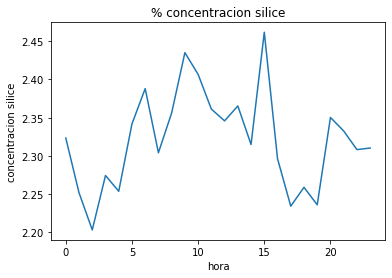

In [301]:
plt.plot(concentracion);
plt.title('% concentracion silice')
plt.xlabel('hora')
plt.ylabel('concentracion silice')

Comentarios:

- La variable que tiene el mayor impacto en % de concentracion de silice es % de concentracion de hierro (impacto negativo). Le siguen  % Silica Feed (positivo), Flotation column 06 Air Flow (negativo) y % Iron Feed (positivo). Interesantemente, las variables Starch Flow, Amina Fow, Ore Pulp Flow y Ore Pulp Ph no parecen tener un impacto tan importante en caracterizar el % de concentracion de silice  como se menciono en las instrucciones.

- En terminos de la evolucion del % de concentracion de silice durante el dia, puedo decir que las horas del dia en que ocurren los mayores incrementos de % de concentracion de silice son a la hora 16, 10 y 11.

## ¿Con cuantos pasos (horas) de anticipacion podemos predecir el % de silice en el concentrado?

Con el modelo anterior la evolucion del % de silice en el concentrado esta caracterizado para todo el dia lo que da tiempo a los ingenieros para prepararse.

## ¿Es posible predecir el % de silice en concentrado sin usar la columna de % de concentrado de hierro (ya que estan altamente correlacionados)?

En el modelo de regresion lasso, el que hace seleccion de variables automaticas, se observa que el % de concentrado de hierro es la mas influyente en el modelo y una de las solo 3 variables que se estiman como influyentes cuando se estandarizan las variables.

Algunas opciones para lidear con su ausencia:\

- hacer un modelo de regresion sin incluir esa variable. Probablemente resultara en un modelo con un r2 bajo ya que poca variabilidad de los datos sera expicada por el modelo
- otra alternativa es ajustar un modelo que prediga el % de concentrado de hierro y usar las predicciones de ese modelo como una de las variables explicativas al momento de ajustar el modelo de % de silice en el concentrado.